<a href="https://colab.research.google.com/github/Tiger-A/GoogleCollab/blob/main/%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0_%7C_%D0%98%D0%BD%D1%82%D0%B5%D0%BD%D1%81%D0%B8%D0%B2_2023_(%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h2 > <b> Домашнее задание №1 </b></h2>
<hr>
<font size=5><i> Треккинг автомобилей </i>

<font size=2>В данном задании Вы создадите систему трекинга гоночных автомобилей. Мы поможем Вам пройти все шаги для создания данной системы.

<h4> Шаг №1. Установка инструментов </h4>
<i> Запустите ячейку ниже для установки всех необходимых инструментов и билиотек </i>

In [ ]:
#@title Сервисные функции
%cd /content
!rm -rf yolov8_tracking
!git clone --recurse-submodules https://github.com/mikel-brostrom/yolov8_tracking.git  # clone repo
!pip -q install -qr yolov8_tracking/requirements.txt  # install dependencies
!pip -q install thop                  # install dependencies
!pip -q install sentry-sdk
!pip -q install ffmpeg-python

import torch
import gdown
from IPython.display import Image, clear_output  # to display images
import ffmpeg
from base64 import b64encode
from IPython.display import HTML
import cv2
import subprocess

clear_output()
print(f"Установка заврешена. Верисия torch: {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

%cd /content/yolov8_tracking

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class Trackingworker():
  URL = 'https://storage.yandexcloud.net/aiueducation/Intensive/v2.0/traf.mp4'
  def __init__(self):
    # открыть файл на чтение
    with open('/content/yolov8_tracking/track.py', 'r') as file:
        # прочитать содержимое файла в строку
        content = file.read()

    # заменить строку
    new_content = content.replace("color = colors(c, True)", "color = colors(id, True)")

    # открыть файл на запись
    with open('/content/yolov8_tracking/track.py', 'w') as file:
        # записать измененную строку в файл
        file.write(new_content)

    pass

  def load_test_video(self):
    print('Загрузка тестового видео', end='')
    self.testname = gdown.download(self.__class__.URL, None, quiet=True)    
    print(f'{bcolors.OKGREEN}{bcolors.BOLD} Done{bcolors.ENDC}')
    # Генерируем ссылку для HTML5-видеоплеера
    video_file = open(self.testname, "rb").read()
    video_url = "data:video/mp4;base64," + b64encode(video_file).decode()
    # Выводим видео
    display(HTML(f'<video width=1000 controls><source src="{video_url}" type="video/mp4"></video>'))

  def run(self, 
          path='test.mp4', 
          path_to_yolo = 'yolov8s.pt',
          path_to_osnet = 'osnet_x0_25_msmt17.pt',
          classes_to_detect = 0,
          save_video=True,
          ):
    !rm -rf /content/yolov8_tracking/runs
    !python track.py --yolo-weights {path_to_yolo} --reid-weights {path_to_osnet} --source {self.testname} --classes {classes_to_detect} --save-vid

  def show_result(self):
    # Чтение первого видео
    video1 = cv2.VideoCapture(self.testname)
    # Чтение второго видео
    video2 = cv2.VideoCapture(f'/content/yolov8_tracking/runs/track/exp/{self.testname}')
    fps = int(video2.get(cv2.CAP_PROP_FPS))
    # Определение ширины и высоты видео
    width = int(video1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video1.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Создание объекта VideoWriter для записи объединенного видео
    writer = cv2.VideoWriter('merged_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width*2, height))

    while True:
        # Чтение кадра из первого видео
        ret1, frame1 = video1.read()
        if not ret1:
            break
        
        # Чтение кадра из второго видео
        ret2, frame2 = video2.read()
        if not ret2:
            break
        
        # Изменение размера кадров до 1280х360
        frame1 = cv2.resize(frame1, (width, height))
        frame2 = cv2.resize(frame2, (width, height))
        
        # Объединение кадров горизонтально
        merged_frame = cv2.hconcat([frame1, frame2])
        
        # Запись объединенного кадра в файл
        writer.write(merged_frame)

    # Освобождение ресурсов
    video1.release()
    video2.release()
    writer.release()

    !rm -rf outputh264.mp4

    input_path = "merged_video.mp4"
    output_path = "outputh264.mp4"

    # Конвертируем видео в кодек H.264
    ffmpeg.input(input_path).output(output_path, vcodec="libx264").run()

    # Генерируем ссылку для HTML5-видеоплеера
    video_file = open(output_path, "rb").read()
    video_url = "data:video/mp4;base64," + b64encode(video_file).decode()

    # Выводим видео
    display(HTML(f'<video width=1600 controls><source src="{video_url}" type="video/mp4"></video>'))

<h4> Шаг №2. Создание объекта Tracking </h4>
<i> Посмотрите первое занятие интенсива и наберите код (в ячейке ниже), который используется для создания объекта Tracking </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Создаем объект Tracking




<h4> Шаг №3. Загрузка тестового видео </h4>
<i> Посмотрите первое занятие интенсива и наберите код (в ячейке ниже), который используется для загрузки тестового видео. </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Загрузка тестового видео




<h4> Шаг №4. Трекинг </h4>
<i> Посмотрите первое занятие интенсива и наберите код (в ячейке ниже), запускает процесс Трекинга </i><br>
<i><b>Важно!</b> Замените класс распознаваемого объекта на автомобильный (в учебном ноутбуке указан класс "человек")</b></i><br>
<i><b>Важно!</b> Замените имя файла `test.mp4` на <b>`traf.mp4`</b></i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Запуск трекера




<h4> Шаг №5. Вывод результата Трекинга</h4>
<i> Посмотрите первое занятие интенсива и наберите код (в ячейке ниже), который выводит результат Трекинга на экран </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Вывод результата




#<h2 > <b> Домашнее задание №2 </b></h2>
<hr>
<font size=5><i> Распознавание данных СНИЛС </i>

<font size=2>В данном задании Вы создадите систему распознавания данных СНИЛС. Мы поможем Вам пройти все шаги для создания данной системы.

<h4> Шаг №1. Установка инструментов </h4>
<i> Запустите ячейку ниже для установки всех необходимых инструментов и билиотек </i>

In [ ]:
#@title *Сервисные функции*
!pip -q install easyocr

import easyocr
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gdown 
import numpy as np

class EasyOCRworker():
  def __init__(self, fields=None):
    self.fields = fields
  
  def download_test_images(self):
    self.test_img_path = gdown.download('https://storage.yandexcloud.net/aiueducation/Intensive/v2.0/SNILS.jpg', None, quiet=True)
    self.show_img(self.test_img_path)

  def show_img(self, img):
    if isinstance(img, str):
      img = cv2.imread(img)    
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

  def recognize(self, lang='ru', img_path=''):
    reader = easyocr.Reader([lang])
    img = cv2.imread(img_path)
    self.results = reader.readtext(img)
    print('Распознавание текста завершено!')

  def recognize_with_border(self, lang='ru', img_path=''):
    # Открывем изображение
    img = mpimg.imread(img_path)

    reader = easyocr.Reader([lang])
    
    # Перебираем все заданные элементы
    for key in self.fields:
      # Получаем границы объекта
      x1, y1, x2, y2 = self.fields[key]

      # Вырезаем фрагмент исходного изображения
      img_crop = img[y1:y2, x1:x2]

      # Номер паспорта необходимо повернуть на 90 градусов (библиотека не распознает вертикальный текст)
      if key=='Номер':
        img_crop = np.rot90(img_crop, k=1, axes=(0, 1))

      # Распознаем текст на вырезанном фрагменте
      results = reader.readtext(img_crop)

      # Выведем на экран распознанный текст и вырезанный фрагмент
      print(f'*** {key} ***')
      text = ''
      for result in results:
        text += result[1].lower() + ' '
          # Show cropped image
      plt.imshow(img_crop)
      plt.axis('off')
      plt.show()  
      print(text)
      print()
      print()

  def set_border_to_img(self, img, results):
    if isinstance(img, str):
        img = cv2.imread(img)
    for i, result in enumerate(results):
      coord1 = list(map((int),result[0][0]))
      coord2 = list(map((int), result[0][2]))
      cv2.rectangle(img, coord1, coord2, (0, 0, 255), 2)
    self.show_img(img)

  def show_result(self):
    # Перебираем все найденные элементы
    for i, result in enumerate(self.results):
      # Сохраняем распознанный текст
      text = result[1].lower()
      # Выводим на экран распознанный текст
      print(f'{i}. {text}')

    # Выполним наложение обнаруженных рамок на исходное изображение
    self.set_border_to_img(self.test_img_path, self.results)

<h4> Шаг №2. Создание объекта easyOCR </h4>
<i> Посмотрите второе занятие интенсива и наберите код (в ячейке ниже), который используется для создания объекта работы с библиотекой EasyOCR. </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Создаем объект для работы с библиотекой EasyOCR




<h4> Шаг №3. Загрузка тестового изображения </h4>
<i> Посмотрите второе занятие интенсива и наберите код (в ячейке ниже), который используется для загрузки тестового изображения. </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Скачаем тестовое изображение паспорта




<h4> Шаг №4. Распознавание текста </h4>
<i> Посмотрите второе занятие интенсива и наберите код (в ячейке ниже), запускает процесс распознавания текста </i><br>
<i><b>Важно!</b> Замените имя файла `Dizel.jpg` на <b>`SNILS.jpg`</b></i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Запускаем распознавание русского текста на текстовом изображении паспорта




<h4> Шаг №5. Вывод результата распознавания на экран </h4>
<i> Посмотрите второе занятие интенсива и наберите код (в ячейке ниже), который выводит результат распознавания на экран </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Отображаем результат распознавания




<h4> Шаг №6*. Улучшение алгоритма </h4>
<i> Давайте попробуем улучшить работу алгоритма по аналогии с занятием. Для этого нужно создать структуру, в которой будут хранится границы распознаваемых блоков. </i><br>
<ul><i>Нам требуется указать границы для:
<li>Номер</li>
<li>ФИО</li>
<li>Дата и место рождения</li>
<li>Город</li>
<li>Пол</li>
<li>Дата регистрации</li>

<i> Мы покажем, как получить границу для блока <b>номер СНИЛС</b>, а остальные границы Вы сделаете сами. </i><br>
1. Перейдите по [ссылке](https://storage.yandexcloud.net/aiueducation/Intensive/v2.0/SNILS.jpg) и скачайте изображение себе на компьютер
2. Откройте изображение с помощью редактора Paint
3. Подведите курсор мыши к левому верхнему углу блока, где располагается номер СНИЛС.
4. Слева внизу редактора Paint Вы увидете координаты (в пикселях). Это первые два значения, которые необходимо указать в нашей структуре, хранящей границы блоков.
5. Переведите курсор мыши в правый нижний угол блока с номером СНИЛС и получите вторую пару значений для заполнения структуры
6. Внесите полученные данные в структуру границ в ячейке ниже
7. Повторите действия для получения границ всех остальных блоков для распознавания

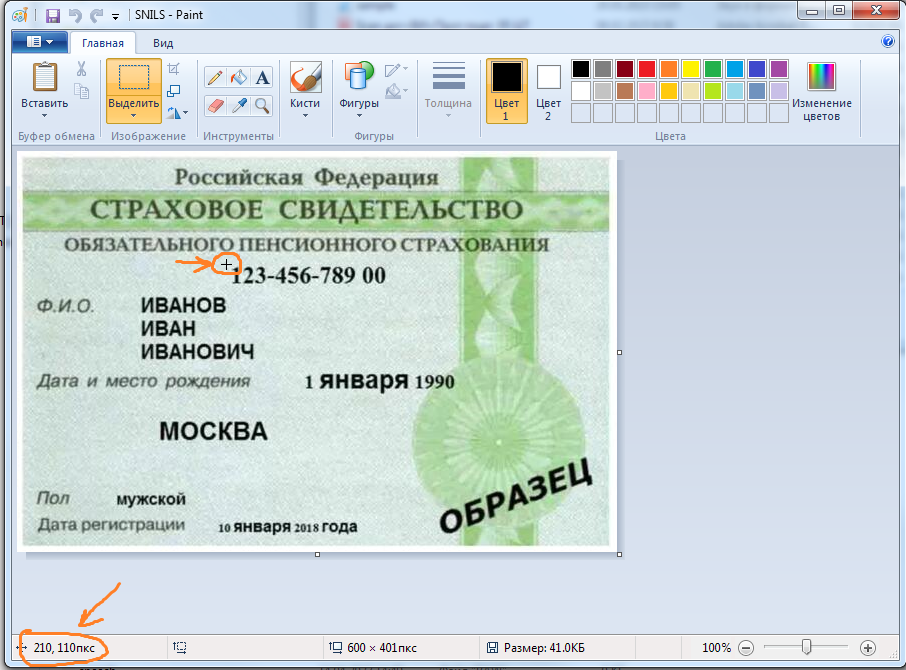

In [ ]:
fields = {
    'Номер СНИЛС': [210, 110, 380, 140],
    'ФИО': [],
    'Дата и место рождения': [],
    'Город': [],
    'Пол': [],
    'Дата регистрации': [],
}

<i> Посмотрите второе занятие интенсива и наберите код (в ячейке ниже), который создает объект easyOCR с указанием границ расопзнаваемых блоков </i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Создаем объект для работы с библиотекой EasyOCR, указав границы рамок




<i> Посмотрите второе занятие интенсива и наберите код (в ячейке ниже), запускаеи распознавание текста с учетом границы </i><br>
<i><b>Важно!</b> Замените имя файла `Dizel.jpg` на <b>`SNILS.jpg`</b></i><br>
<i>После этого запустите ячейку</i>

In [ ]:
# Запускаем распознавание русского текста на текстовом изображении паспорта с учетом границ




#<h2 > <b> Домашнее задание №3 </b></h2>
<hr>
<font size=5><i> Генерация StableDiffusion </i>

<font size=2>В данном задании попробуйте сгенерировать изображение с помощью StableDiffusion на тему: <b>Искусственный интеллект помогает человеку</b>

<h4> Шаг №1. Установка инструментов и создание объекта StableDiffusion</h4>
<i> Запустите ячейки ниже для установки всех необходимых инструментов и билиотек </i>

In [ ]:
#@title Сервисные функции
!pip -q install diffusers==0.10.0
!pip -q install transformers scipy ftfy accelerate
!pip -q install "ipywidgets>=7,<8"
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

from google.colab import output
output.enable_custom_widget_manager()

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  display(grid)

In [ ]:
stableDiffusion = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)

In [ ]:
stableDiffusion = stableDiffusion.to("cuda")

<h4> Шаг №2. Генерация</h4>
<i> Введите текст запроса в переменную prompt и запустите ячейку ниже </i>
<i> Вы можете менять текст запроса, можете запускать ячейку несколько раз для генерации различных вариантов </i>

In [ ]:
# Укажем количество генерируемых изображений (рекомендуемое значение 5 (на большее количество может не хватить ресурсов google Colab))
num_images = 5

# Зададим prompt(базис) для генерации
prompt = ''

# Зададим количество итераций генерации (чем больше, тем детализированне будет финальное изображение)
num_inference_steps = 100

# Запускаем генерацию
images =  stableDiffusion(
    [prompt] * num_images, 
    num_inference_steps=num_inference_steps, 
    ).images

# Выводим на экран сгенерированные изображения
image_grid(images, rows=1, cols=num_images)